## ひらがな手書きの文字認識

### データのダウンロード（NDL LABからひらがなのデータ）

In [1]:
%matplotlib inline

In [2]:
notebook_id = %env TRAINING_NOTEBOOK_ID
%cd '/mnt/notebooks/{notebook_id}/Platform_handson/hiragana_classify'

/mnt/notebooks/1736464579666/Platform_handson/hiragana_classify


In [4]:
# home配下にdataを配置する
!wget http://lab.ndl.go.jp/dataset/hiragana73.zip -P /home/data

--2019-04-13 12:49:49--  http://lab.ndl.go.jp/dataset/hiragana73.zip
Resolving lab.ndl.go.jp (lab.ndl.go.jp)... 202.32.173.150
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://lab.ndl.go.jp/dataset/hiragana73.zip [following]
--2019-04-13 12:49:49--  https://lab.ndl.go.jp/dataset/hiragana73.zip
Connecting to lab.ndl.go.jp (lab.ndl.go.jp)|202.32.173.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233312433 (223M) [application/zip]
Saving to: ‘/home/data/hiragana73.zip’

hiragana73.zip      100%[===================>] 222.50M  13.6MB/s    in 17s     

2019-04-13 12:50:06 (12.7 MB/s) - ‘/home/data/hiragana73.zip’ saved [233312433/233312433]



In [5]:
!unzip -o -q /home/data/hiragana73.zip -d /home/data/

In [6]:
# フォルダのリネーム（命名がユニコードになっているので、indexに変換する）
!sh ./tool/rename.sh

In [7]:
ls -al /home/data/hiragana73

total 4676
drwxr-xr-x 75 root root  4096 Apr 13 12:50 ./
drwxr-xr-x  3 root root    46 Apr 13 12:50 ../
drwxr-xr-x  2 root root 45056 Sep  8  2016 0/
drwxr-xr-x  2 root root 45056 Sep  8  2016 1/
drwxr-xr-x  2 root root 40960 Sep  8  2016 10/
drwxr-xr-x  2 root root 45056 Sep  8  2016 11/
drwxr-xr-x  2 root root 40960 Sep  8  2016 12/
drwxr-xr-x  2 root root 45056 Sep  8  2016 13/
drwxr-xr-x  2 root root 40960 Sep  8  2016 14/
drwxr-xr-x  2 root root 49152 Sep  8  2016 15/
drwxr-xr-x  2 root root 40960 Sep  8  2016 16/
drwxr-xr-x  2 root root 49152 Sep  8  2016 17/
drwxr-xr-x  2 root root 40960 Sep  8  2016 18/
drwxr-xr-x  2 root root 49152 Sep  8  2016 19/
drwxr-xr-x  2 root root 45056 Sep  8  2016 2/
drwxr-xr-x  2 root root 40960 Sep  8  2016 20/
drwxr-xr-x  2 root root 45056 Sep  8  2016 21/
drwxr-xr-x  2 root root 45056 Sep  8  2016 22/
drwxr-xr-x  2 root root 49152 Sep  8  2016 23/
drwxr-xr-x  2 root root 40960 Sep  8  2016 24/
drwxr-xr-x  2 root root 49152 Sep  8  2016 25/
drwxr-

In [8]:
# フォルダの一覧を取得する(hiragana73配下)
import os
path = "/home/data/hiragana73/"
folder = os.listdir(path)

### 前処理

In [9]:
import glob
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import numpy as np
import random
image_size = 48
 
X_train = []
Y_train = []
X_test = []
Y_test = []
for index, name in tqdm(enumerate(folder), total=len(folder)):
  
    #フォルダの一覧をリストとして取得する
    dir = path + name
    files = glob.glob(dir + "/*.png")
    random.shuffle(files)
    
    # 学習とテストで 8:2 のデータ割合に分ける
    split_num = len(files)*0.8
    num = 0
    for i, file in enumerate(files):
      image = Image.open(file)
      image = image.convert("RGB")
      #image = image.convert('L')
      image = image.resize((image_size, image_size))
      data = np.asarray(image)
      if split_num > num:
        X_train.append(data)
        Y_train.append(name)
      else:
        X_test.append(data)
        Y_test.append(name)
      num += 1
 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [10]:
# ラベルと対象データを確認
Y_test[1]

'41'

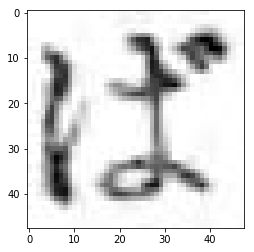

In [11]:
import matplotlib.pyplot as plt
im_list = np.asarray(X_train[1])
plt.imshow(im_list)
plt.show()

In [12]:
# trainとtestがデータが分割されていることを確認する
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

64027
64027
15973
15973


In [13]:
# 0-255の整数値を0〜1の小数に変換する(正規化)
X_train_orig = X_train
X_test_orig = X_test
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [14]:
# one-hot vector形式に変換する
from keras.utils import np_utils
Y_train = np_utils.to_categorical(Y_train, 73)
Y_test = np_utils.to_categorical(Y_test, 73)

Using TensorFlow backend.


In [15]:
# モデルの定義（別資料にて説明）
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))

In [16]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [17]:
history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Train on 64027 samples, validate on 15973 samples
Epoch 1/20
64027/64027 [==============================] - 16s 252us/step - loss: 4.2177 - acc: 0.0281 - val_loss: 3.8969 - val_acc: 0.1086
Epoch 2/20
64027/64027 [==============================] - 14s 220us/step - loss: 2.5228 - acc: 0.3460 - val_loss: 0.9473 - val_acc: 0.8142
Epoch 3/20
64027/64027 [==============================] - 14s 219us/step - loss: 0.9665 - acc: 0.7291 - val_loss: 0.3753 - val_acc: 0.9182
Epoch 4/20
64027/64027 [==============================] - 14s 220us/step - loss: 0.5372 - acc: 0.8478 - val_loss: 0.2436 - val_acc: 0.9414
Epoch 5/20
64027/64027 [==============================] - 14s 219us/step - loss: 0.3730 - acc: 0.8962 - val_loss: 0.1757 - val_acc: 0.9569
Epoch 6/20
64027/64027 [==============================] - 14s 220us/step - loss: 0.2856 - acc: 0.9198 - val_loss: 0.1398 - val_acc: 0.9650
Epoch 7/20
64027/64027 [==============================] - 14s 219us/step - loss: 0.2324 - acc: 0.9342 - val_loss: 0.

In [18]:
predict = model.predict(X_test)

In [19]:
len(predict)

15973

In [20]:
# ラベルの設定
label = ["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]

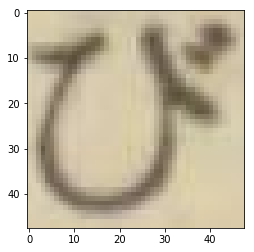

In [21]:
import matplotlib.pyplot as plt
ind = 500
im_list = np.asarray(X_test_orig[ind])
plt.imshow(im_list)
plt.show()

In [22]:
label[predict[ind].tolist().index(max(predict[ind]))]

'び'

In [23]:
#モデルの保存
model.save('./model/hiragana_model.h5', include_optimizer=False)

In [24]:
from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

jpg_name = ''

model=load_model('./model/hiragana_model.h5')

img_path = ('./sample/test2.png')
img = img_to_array(load_img(img_path, target_size=(48,48)))
img_nad = img_to_array(img)/255
img_nad = img_nad[None, ...]

label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
pred = model.predict(img_nad, batch_size=1, verbose=0)
score = np.max(pred)
pred_label = label[np.argmax(pred[0])]
print('name:',pred_label)
print('score:',score)

name: う
score: 0.99945074


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
# HTTPサーバに組みこむ際のサンプルコード
from keras.models import load_model
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

model=load_model('./model/hiragana_model.h5')

def process_image(img):
    img = Image.fromarray(img)
    img = img.resize((48, 48)).convert('RGB')
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x, mode='tf')

    label=["あ","い","う","え","お","か","が","き","ぎ","く","ぐ","け","げ","こ","ご","さ","ざ","し","じ","す","ず","せ","ぜ","そ","ぞ","た","だ","ち","ぢ","つ","づ","て","で","と","ど","な","に","ぬ","ね","の","は","ば","ぱ","ひ","び","ぴ","ふ","ぶ","ぷ","へ","べ","ぺ","ほ","ぼ","ぽ","ま","み","む","め","も","や","ゆ","よ","ら","り","る","れ","ろ","わ","ゐ","ゑ","を","ん"]
    pred = model.predict(x,verbose=0)[0]
    print(pred)
    result_with_labels = [{"label": label[i], "probability": float(score)} for i, score in enumerate(pred)]
    result = {"result":sorted(result_with_labels, key=lambda x: x['probability'], reverse=True)[:5]}

    return result

def handler(iter, context):
    for img in iter:
        yield process_image(img)

In [26]:
#img = Image.open('./test.png')
img = Image.open('./sample/test4.png')
img = np.asarray(img)
process_image(img)

[1.35790484e-04 5.81112714e-10 5.24915968e-08 9.25519943e-01
 2.46695490e-05 1.62840124e-08 2.00574704e-08 1.18738653e-05
 6.42076020e-06 4.42745041e-08 2.47442378e-09 1.81541865e-11
 2.97904821e-13 8.09009871e-05 4.93665138e-05 2.43332324e-04
 1.22611213e-03 1.47947077e-07 6.76958436e-08 6.12268707e-07
 3.84866787e-08 3.92224697e-09 4.18462140e-11 1.50690212e-07
 1.09322928e-09 5.10494003e-09 1.24357313e-09 2.53504617e-09
 3.17692296e-11 4.71554067e-08 9.15376663e-11 5.26062104e-06
 9.59134883e-10 5.44857641e-04 3.05112080e-05 4.36034315e-06
 2.69955294e-08 2.16253483e-07 2.00337396e-07 7.63044561e-09
 7.95398228e-06 9.30152419e-06 1.78968179e-07 1.45800470e-06
 1.87030821e-07 7.03191602e-11 1.30277337e-03 5.34822873e-04
 3.52194038e-05 4.02758438e-10 3.44380453e-07 7.01087011e-09
 9.69335758e-08 2.45441879e-05 1.07977485e-07 1.11616058e-02
 4.21918448e-05 2.89824631e-09 1.21240760e-08 3.30608088e-07
 6.27947347e-12 5.18615706e-11 5.16360477e-02 3.87913673e-07
 1.70439884e-09 6.964647

{'result': [{'label': 'え', 'probability': 0.9255199432373047},
  {'label': 'よ', 'probability': 0.051636047661304474},
  {'label': 'ま', 'probability': 0.011161605827510357},
  {'label': 'る', 'probability': 0.006964647676795721},
  {'label': 'ふ', 'probability': 0.0013027733657509089}]}

In [ ]:
!apt-get update
!apt-get install zip

この後、modelフォルダに存在するh5ファイルとmain.pyを圧縮し
ABEJA Platform上にアップロードすることで、HTTPサーバとして活用可能

## Imagegeneratorを使う場合(参考程度に記載)

In [27]:
from keras.preprocessing.image import ImageDataGenerator

In [28]:
datagen = ImageDataGenerator(rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set test split

In [29]:
dir = '/home/data/hiragana73'
train_generator = datagen.flow_from_directory(
        dir,     # directory
        target_size=(48, 48),     # input shape (resized to 150x150)
        batch_size=20,
        class_mode='categorical')    # categorical labels

Found 80000 images belonging to 73 classes.


In [30]:
test_generator = datagen.flow_from_directory(
    dir, # same directory as training data
    target_size=(48, 48),
    batch_size=20,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 15973 images belonging to 73 classes.


In [31]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(73, activation='softmax'))

from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [32]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=354,
      epochs=20,
      validation_data=test_generator,
      validation_steps=56)

Epoch 1/20
354/354 [==============================] - 5s 13ms/step - loss: 4.2763 - acc: 0.0158 - val_loss: 4.2644 - val_acc: 0.0259
Epoch 2/20
354/354 [==============================] - 4s 11ms/step - loss: 4.2617 - acc: 0.0186 - val_loss: 4.2482 - val_acc: 0.0152
Epoch 3/20
354/354 [==============================] - 4s 11ms/step - loss: 4.2463 - acc: 0.0181 - val_loss: 4.1977 - val_acc: 0.0679
Epoch 4/20
354/354 [==============================] - 4s 11ms/step - loss: 4.1406 - acc: 0.0429 - val_loss: 3.8694 - val_acc: 0.1366
Epoch 5/20
354/354 [==============================] - 4s 11ms/step - loss: 3.7128 - acc: 0.1062 - val_loss: 3.0675 - val_acc: 0.2679
Epoch 6/20
354/354 [==============================] - 4s 11ms/step - loss: 3.0739 - acc: 0.2129 - val_loss: 2.3401 - val_acc: 0.4295
Epoch 7/20
354/354 [==============================] - 4s 11ms/step - loss: 2.6080 - acc: 0.3052 - val_loss: 1.7200 - val_acc: 0.6009
Epoch 8/20
354/354 [==============================] - 4s 11ms/step - 

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

test_loss, test_acc = model.evaluate_generator(test_generator, steps=54)
print('test loss:', test_loss)
print('test acc:', test_acc)